In [1]:
%load_ext autoreload
%autoreload 2

# 3rd party imports
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
np.set_printoptions(linewidth=1000)

from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint


# Local imports
import modules.laplacian as laplacian
import modules.jacobian as jacobian
import modules.correspondences as correspondences

import time

In [ ]:
# Define global var
threshold = 0.05
max_iter = 1000

list_dev = []
num_neg_jac_init = []
num_neg_jac = []
time_taken = []
full_start = time.time()

## Full SLSQP

In [3]:
# Define the objective function
def objective(phi, phi_init, A_, b_):
    return np.linalg.norm(A_ @ phi - b_)**2

# Define the objective function

def objectiveEuc(phi, phi_init, A_, b_):
    return np.linalg.norm(phi - phi_init)

def objectiveEuc2(phi, phi_init, A_, b_):
    return np.linalg.norm(phi - phi_init) + np.linalg.norm(A_ @ phi - b_)

def objectiveManh(phi, phi_init, A_, b_):
    return np.linalg.norm(phi - phi_init, ord=1)

def objectiveManh2(phi, phi_init, A_, b_):
    return np.linalg.norm(phi - phi_init, ord=1) + np.linalg.norm(A_ @ phi - b_)


In [4]:
# jacobian functions

def jacobian_det2D(phi_xy):
    deformation = np.zeros((3,1, *phi_xy.shape[-2:]))
    deformation[2] = phi_xy[1]
    deformation[1] = phi_xy[0]
    return jacobian.sitk_jacobian_determinant(deformation)

def jacobian_constraint(phi_xy, slice_shape, y_offset):
    deformation = np.zeros((3,1, *slice_shape[-2:]))
    deformation[2] = phi_xy[:y_offset].reshape((slice_shape[2], slice_shape[3]))
    deformation[1] = phi_xy[y_offset:].reshape((slice_shape[2], slice_shape[3]))
    return jacobian.sitk_jacobian_determinant(deformation).flatten()

In [ ]:
def full_slsqp(deformation_i, methodName='SLSQP'):
    '''perform SLSQP on full image'''
    time_start = time.time()

    slice_shape = deformation_i.shape

    # this phi will be updated iteratively
    phi_init = np.zeros((2, *deformation_i.shape[-2:]))
    phi_init[1] = deformation_i[-1]
    phi_init[0] = deformation_i[-2]
    print(f'deformation_i shape: {deformation_i.shape}, phi_init shape: {phi_init.shape}')
    
    phi_init_flat = np.concatenate([phi_init[1].flatten(), phi_init[0].flatten()])
    phi = phi_init.copy()

    # collect indices with -ve Jacobians into a list in a sorted fashion
    J_init = jacobian_det2D(phi_init)
    
    y_offset = J_init.size

    nonlinear_constraints = NonlinearConstraint(lambda phi1: jacobian_constraint(phi1, slice_shape, y_offset), threshold, np.inf)
    constraints=nonlinear_constraints

    _, A_, b_ = laplacian.compute3DLaplacianFromShape(slice_shape, np.empty((0,3)), np.empty((0,3)))

    result = minimize(lambda phi1: objectiveManh(phi1, phi_init_flat, A_, b_), phi_init_flat, constraints=constraints, options={'maxiter': max_iter, 'disp': True}, method=methodName)
    if result.success:
        print(f'OP result error: {result.fun}')
    else:
        print("Optimisation failed: ", result.message)


    phi[1] = result.x[:len(result.x) // 2].reshape(slice_shape[-2:])
    phi[0] = result.x[len(result.x) // 2:].reshape(slice_shape[-2:])

    J_final = jacobian_det2D(phi)
    jacobians = [J_init, J_final]

    deviation = np.sqrt(np.sum((phi - phi_init)**2))

    print(f'Deviation from initial = {deviation}')
    print(f'Changed number of -ve jacobians from {(J_init<=0).sum()} to {(J_final<=0).sum()}')

    time_end = time.time()
    print(f'Time taken for full SLSQP optimisation: {time_end-time_start}s')

    # add to global var list
    list_dev.append(deviation)
    num_neg_jac_init.append((J_init<=0).sum())
    num_neg_jac.append((J_final<=0).sum())
    time_taken.append(time_end-time_start)

    return phi, jacobians

## preprocessing and plotting methods

In [6]:
def plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10,10)):
    jacobian_initial = jacobian_det2D(deformation_i[1:])
    jacobian_final = jacobian_det2D(phi_corrected)

    # print("JACOBIAN SHAPES", jacobian_initial.shape, jacobian_final.shape)

    # Create DataFrame
    data = {
        ("x-def", "min"): [np.min(deformation_i[2,0]), np.min(phi_corrected[1])],
        ("x-def", "max"): [np.max(deformation_i[2,0]), np.max(phi_corrected[1])],
        ("y-def", "min"): [np.min(deformation_i[1,0]), np.min(phi_corrected[0])],
        ("y-def", "max"): [np.max(deformation_i[1,0]), np.max(phi_corrected[0])],
        ("jacobian", "min"): [np.min(jacobian_initial), np.min(jacobian_final)],
        ("jacobian", "max"): [np.max(jacobian_initial), np.max(jacobian_final)]
    }

    row_names = ["initial", "final"]
    df = pd.DataFrame(data, index=row_names)

    # Print table
    print(df)


    # plot initial vs final Jacobian
    norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_initial.min(), jacobian_final.min(), -1), vcenter=0, vmax=max(jacobian_initial.max(), jacobian_final.max(), 1))


    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize)

    # jacobians are of shape (1,5,5). Use index [0] for 2D plots
    im0 = axs[0,0].imshow(jacobian_initial[0], cmap='seismic', norm=norm, interpolation='nearest')
    im1 = axs[0,1].imshow(jacobian_final[0], cmap='seismic', norm=norm, interpolation='nearest')

    for i in range(len(msample)):  # Draw lines connecting the points
        axs[0,0].annotate(
            '', 
            xy=(fsample[i][2], fsample[i][1]), 
            xytext=(msample[i][2], msample[i][1]), 
            arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
        )
    
    # Create a grid of points
    x, y = np.meshgrid(range(deformation_i.shape[3]), range(deformation_i.shape[2]), indexing='xy')
    print(f'meshgrid shape for plot: {x.shape}')
    
    axs[0,0].set_title('Initial J det')
    axs[0,0].scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
    axs[0,0].scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
    axs[0,0].legend()

    axs[0,1].set_title('final J det')

    axs[1,0].set_title('Initial deformation')
    axs[1,0].quiver(x, y, -deformation_i[2,0], deformation_i[1,0])

    axs[1,1].set_title('final deformation')
    axs[1,1].quiver(x, y, -phi_corrected[1], phi_corrected[0])

    for i in range(2):
        axs[1,i].invert_yaxis()
    
    #fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.95, 0.5, 0.02, 0.4])
    fig.colorbar(im1, cax=cax)

In [7]:
def plot_jacobians_iteratively(jacobians, msample, fsample, methodName='SLSQP'):
    # assume jacobians is a list of numpy arrays of shape (1, 5, 5)
    # assume msample and fsample are (N, 3) arrays

    num_jacobians = len(jacobians)
    ncols = min(2, num_jacobians)  # wrap at 2 columns
    nrows = (num_jacobians + ncols - 1) // ncols  # ceiling division

    # Compute color normalization
    all_vals = [j[0] for j in jacobians]  # extract 2D arrays from (1,5,5)
    vmin = min(j.min() for j in all_vals)
    vmax = max(j.max() for j in all_vals)
    norm = mcolors.TwoSlopeNorm(vmin=min(vmin, -1), vcenter=0, vmax=max(vmax, 1))

    # Create subplots
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
    axs = axs.flatten()

    for i, jac in enumerate(jacobians):
        im = axs[i].imshow(jac[0], cmap='seismic', norm=norm, interpolation='nearest')
        num_negs = np.sum(jac <= 0)
        axs[i].set_title(f'Jacobian #{i}, {num_negs} -ves' if i > 0 else f'Initial J det: {num_negs} -ves')

        if i == 0:
            axs[i].scatter(msample[:, 2], msample[:, 1], c='g', label='Moving', s=10)
            axs[i].scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed', s=10)
            axs[i].legend()

    for i in range(len(msample)):  # Draw lines connecting the points
        axs[0].annotate(
            '', 
            xy=(fsample[i][2], fsample[i][1]), 
            xytext=(msample[i][2], msample[i][1]), 
            arrowprops=dict(facecolor='black', shrink=0.1, headwidth=3, headlength=5, width=1)
        )

    # Hide any extra axes
    for j in range(len(jacobians), len(axs)):
        axs[j].axis('off')

    # Add colorbar
    # cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    # fig.colorbar(im, cax=cax)
    fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.046, pad=0.04)

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

def run_lapl_and_correction(fixed_sample, msample, fsample, methodName='SLSQP'):
    '''plot each Jacobian matrix'''
    deformation_i, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
    print(f'deformation shape: {deformation_i.shape}')
    phi_corrected, jacobians = full_slsqp(deformation_i, methodName)
    # plot_jacobians_iteratively(jacobians, msample, fsample, methodName='SLSQP')
    plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10,10))

## Some more testcases

deformation shape: (3, 1, 20, 40)
deformation_i shape: (3, 1, 20, 40), phi_init shape: (2, 20, 40)
Iteration limit reached    (Exit mode 9)
            Current function value: 0.10152498414681872
            Iterations: 1000
            Function evaluations: 1608342
            Gradient evaluations: 1000
Optimisation failed:  Iteration limit reached
Deviation from initial = 0.022994862876051545
Changed number of -ve jacobians from 12 to 12
Time taken for full SLSQP optimisation: 5987.0680372715s
            x-def              y-def            jacobian          
              min       max      min       max       min       max
initial -4.999267  8.998681  0.00000  1.998764 -1.150262  2.877145
final   -4.998926  8.988423 -0.00004  1.998773 -1.143291  2.871813
meshgrid shape for plot: (20, 40)


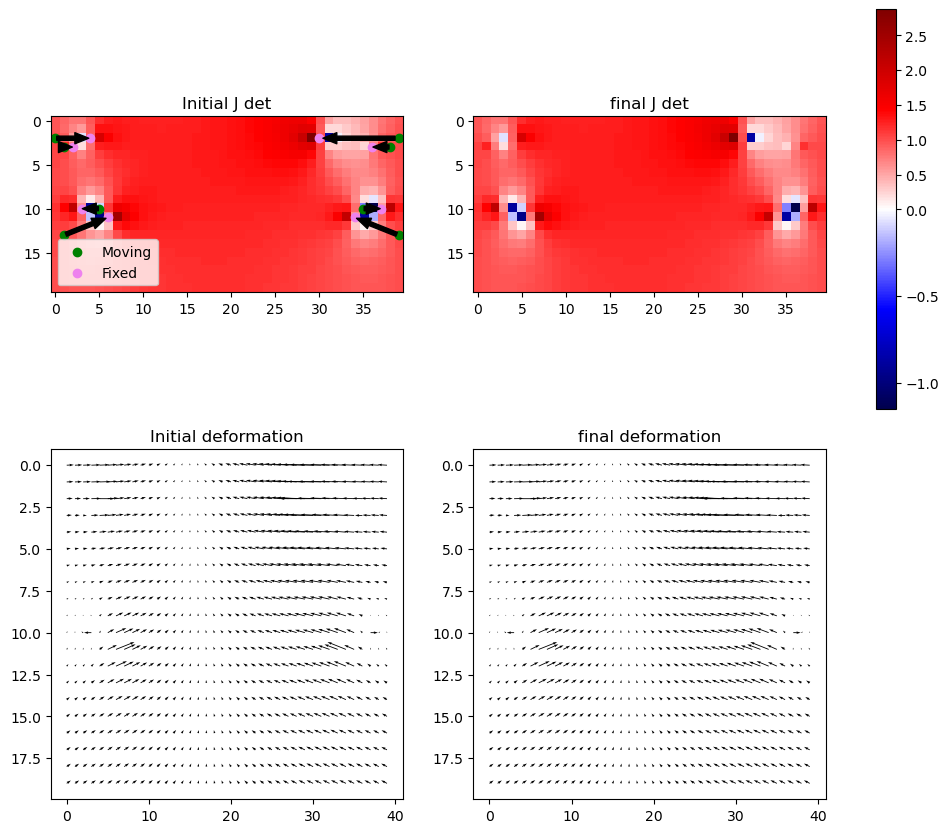

In [8]:
msample = np.array([
    [0, 2, 0],
    [0, 3, 1],
    [0, 10, 5],
    [0, 13, 1],
    [0, 2, 39],
    [0, 3, 38],
    [0, 10, 35],
    [0, 13, 39],
])
fsample = np.array([
    [0, 2, 4],
    [0, 3, 2],
    [0, 10, 3],
    [0, 11, 6],
    [0, 2, 30],
    [0, 3, 36],
    [0, 10, 37],
    [0, 11, 34]
])

fixed_sample = np.zeros((1, 20, 40))

run_lapl_and_correction(fixed_sample, msample, fsample)

deformation shape: (3, 1, 20, 40)
deformation_i shape: (3, 1, 20, 40), phi_init shape: (2, 20, 40)
Iteration limit reached    (Exit mode 9)
            Current function value: 223.47703743143728
            Iterations: 1000
            Function evaluations: 1604949
            Gradient evaluations: 1000
Optimisation failed:  Iteration limit reached
Deviation from initial = 21.514991193353154
Changed number of -ve jacobians from 158 to 0
Time taken for full SLSQP optimisation: 5916.094465017319s
             x-def                 y-def            jacobian          
               min        max        min       max       min       max
initial -19.976474  19.976474 -10.001746 -9.289016 -3.369923  4.326747
final   -19.975295  19.977018 -16.141477 -6.005100  0.018906  1.933020
meshgrid shape for plot: (20, 40)


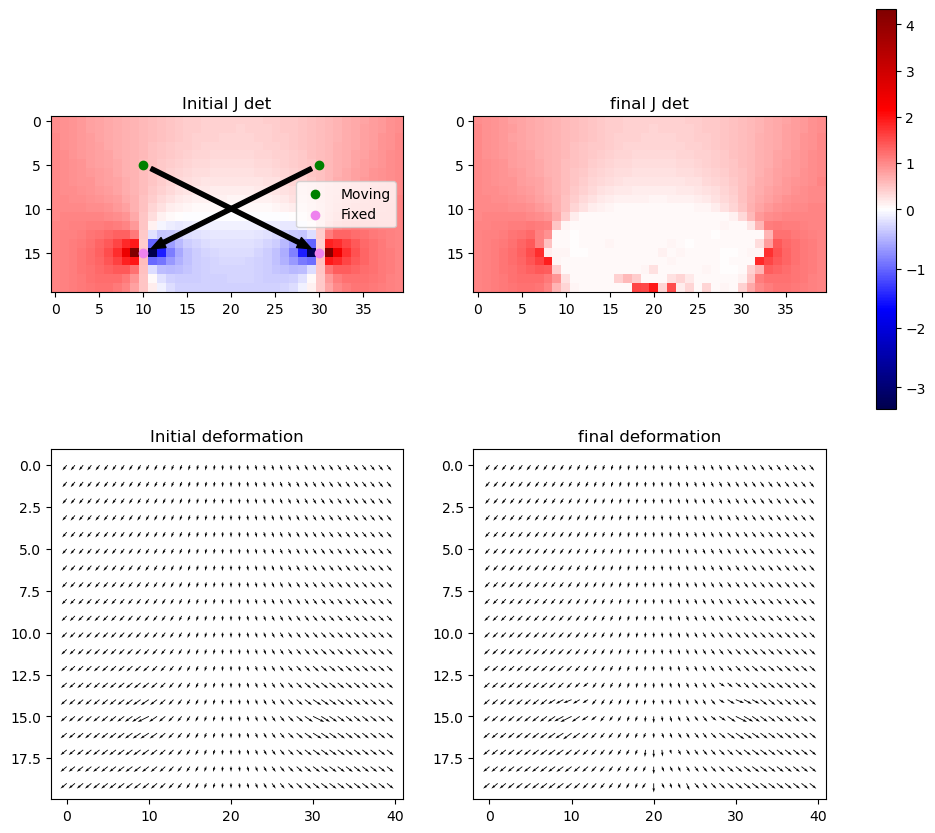

In [9]:
msample = np.array([
    [0, 5, 10],
    [0, 5, 30],
])
fsample = np.array([
    [0, 15, 30],
    [0, 15, 10],
])

fixed_sample = np.zeros((1, 20, 40))

run_lapl_and_correction(fixed_sample, msample, fsample)

# 600 iterations
# 83min - final size 9x9

deformation shape: (3, 1, 20, 40)
deformation_i shape: (3, 1, 20, 40), phi_init shape: (2, 20, 40)
Iteration limit reached    (Exit mode 9)
            Current function value: 89.10549407100562
            Iterations: 1000
            Function evaluations: 1606211
            Gradient evaluations: 1000
Optimisation failed:  Iteration limit reached
Deviation from initial = 14.586022456917528
Changed number of -ve jacobians from 28 to 2
Time taken for full SLSQP optimisation: 5769.77891087532s
             x-def                 y-def             jacobian          
               min        max        min        max       min       max
initial -19.998859 -17.782671 -10.001314  10.001314 -2.028319  3.164794
final   -27.920988 -12.679335  -9.990481   6.575464 -0.061337  2.272471
meshgrid shape for plot: (20, 40)


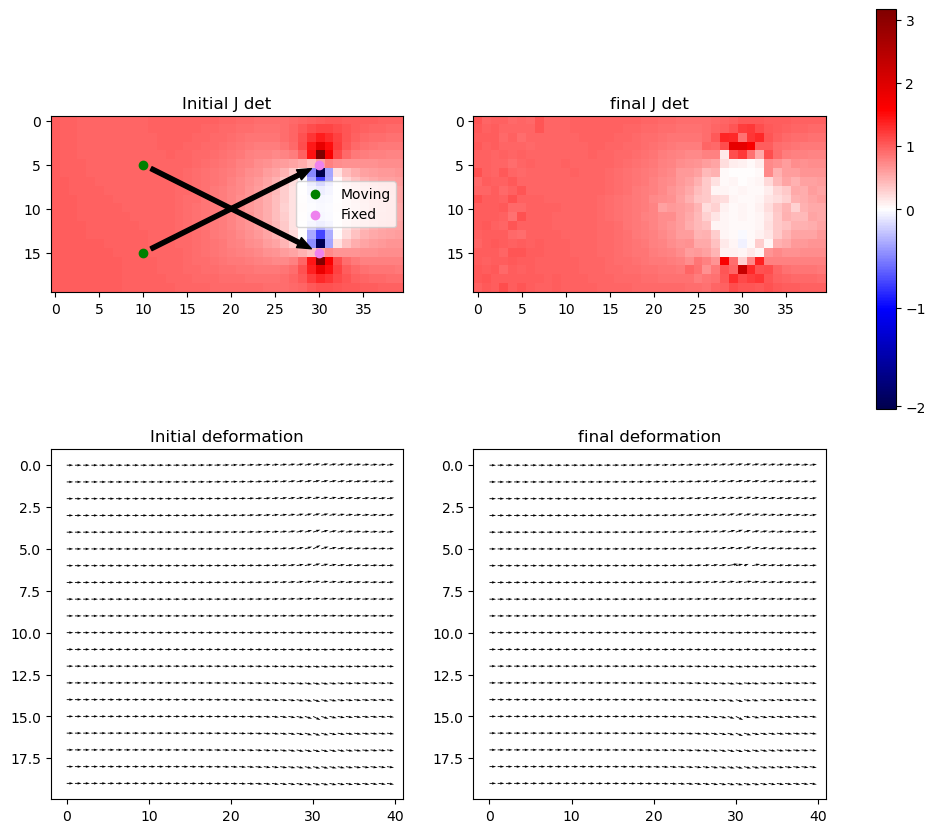

In [10]:
msample = np.array([
    [0, 5, 10],
    [0, 15, 10],
])
fsample = np.array([
    [0, 15, 30],
    [0, 5, 30],
])

fixed_sample = np.zeros((1, 20, 40))

run_lapl_and_correction(fixed_sample, msample, fsample)

msample = np.array([
    [0, 5, 10],
    [0, 5, 30],
])
fsample = np.array([
    [0, 15, 30],
    [0, 15, 10],
])

fixed_sample = np.zeros((1, 20, 40))

run_lapl_and_correction(fixed_sample, msample, fsample)

# not all iterations take the same time?
# Iter 1 Optimisation for index 611 completed in 0.7802479267120361s
# Iter 635 Optimisation for index 693 completed in 278.3064708709717s
# Iter 573 Optimisation for index 494 completed in 63.11005783081055s
# total time 175m - unfinished

deformation shape: (3, 1, 20, 40)
deformation_i shape: (3, 1, 20, 40), phi_init shape: (2, 20, 40)
Iteration limit reached    (Exit mode 9)
            Current function value: 0.011002790143164624
            Iterations: 1000
            Function evaluations: 1608428
            Gradient evaluations: 1000
Optimisation failed:  Iteration limit reached
Deviation from initial = 0.0018485499874402274
Changed number of -ve jacobians from 29 to 29
Time taken for full SLSQP optimisation: 5455.7939467430115s
            x-def               y-def            jacobian          
              min       max       min       max       min       max
initial -6.999377  4.999555 -4.999602  3.999682 -1.343039  4.142665
final   -6.999377  4.999553 -4.999603  3.999556 -1.342546  4.142667
meshgrid shape for plot: (20, 40)


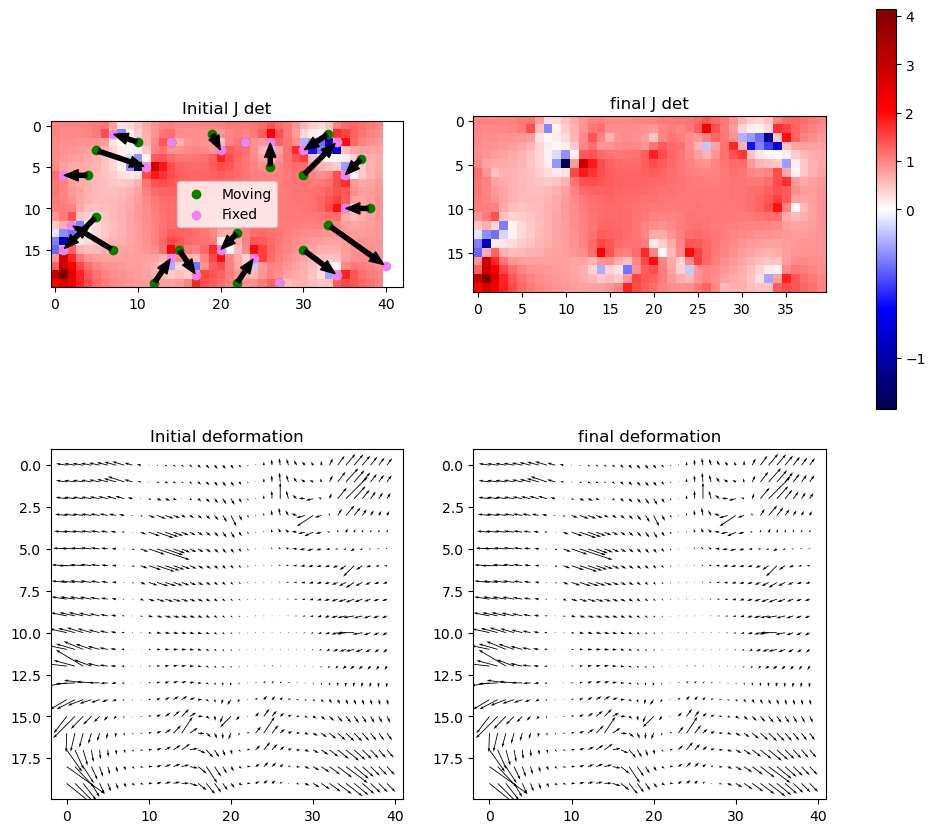

In [12]:
msample = np.array([
    [0, 2, 10],
    [0, 3, 5],
    [0, 6, 4],
    [0, 11, 5],
    [0, 15, 7],
    [0, 19, 12],
    [0, 15, 15],
    [0, 13, 22],
    [0, 19, 22],
    [0, 19, 27],
    [0, 15, 30],
    [0, 12, 33],
    [0, 10, 38],
    [0, 4, 37],
    [0, 6, 30],
    [0, 1, 33],
    [0, 5, 26],
    [0, 2, 23],
    [0, 1, 19],
    [0, 2, 14],
])
fsample = np.array([
    [0, 1, 7],
    [0, 5, 11],
    [0, 6, 1],
    [0, 15, 1],
    [0, 12, 2],
    [0, 16, 14],
    [0, 18, 17],
    [0, 15, 20],
    [0, 16, 24],
    [0, 19, 27],
    [0, 18, 34],
    [0, 17, 40],
    [0, 10, 35],
    [0, 6, 35],
    [0, 2, 34],
    [0, 3, 30],
    [0, 2, 26],
    [0, 2, 23],
    [0, 3, 20],
    [0, 2, 14],
])

fixed_sample = np.zeros((1, 20, 40))

run_lapl_and_correction(fixed_sample, msample, fsample)

## Testcases

deformation shape: (3, 1, 5, 6)
deformation_i shape: (3, 1, 5, 6), phi_init shape: (2, 5, 6)
Iteration limit reached    (Exit mode 9)
            Current function value: 3.964591437425012
            Iterations: 1000
            Function evaluations: 61999
            Gradient evaluations: 1000
Optimisation failed:  Iteration limit reached
Deviation from initial = 2.0722404366878195
Changed number of -ve jacobians from 5 to 0
Time taken for full SLSQP optimisation: 169.70629239082336s
            x-def               y-def            jacobian          
              min       max       min       max       min       max
initial -2.999709  2.999709  0.000000  0.000000 -0.728471  1.547029
final   -2.832658  1.620703 -0.000634  0.027794  0.050000  1.463629
meshgrid shape for plot: (5, 6)


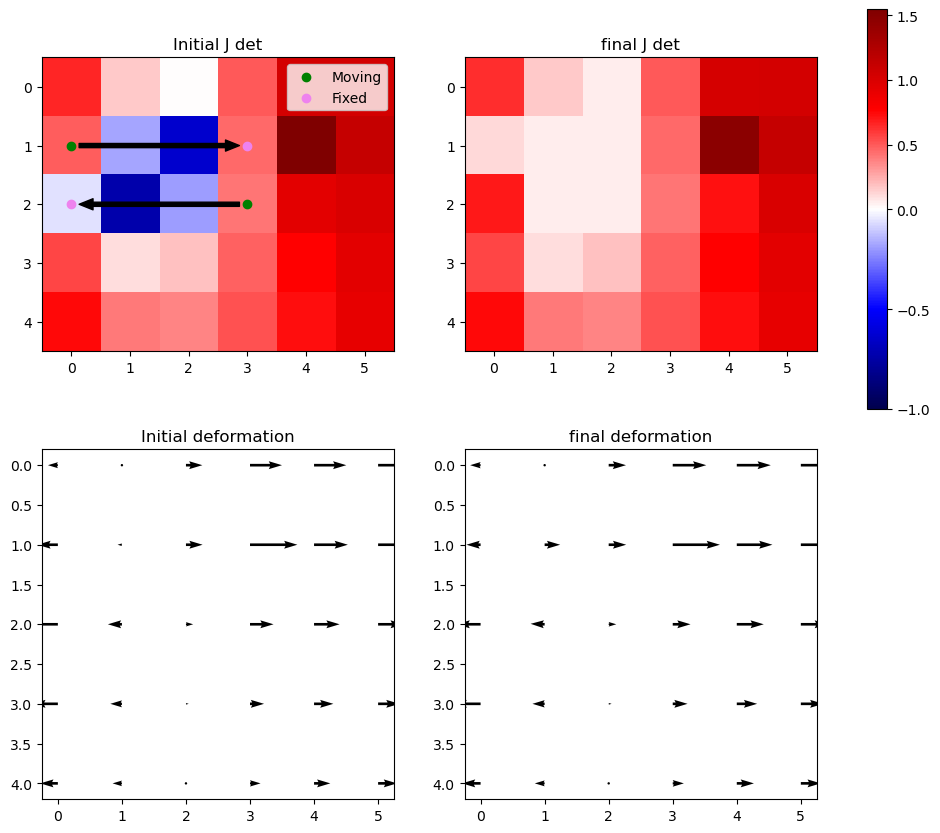

In [13]:
msample = np.array([
    [0, 1, 0],
    [0, 2, 3],
])
fsample = np.array([
    [0, 1, 3],
    [0, 2, 0],
])

fixed_sample = np.zeros((1, 5, 6)) # depth, rows, cols

run_lapl_and_correction(fixed_sample, msample, fsample)

# takes 15 mins and does not conclude on full 20x40 constraints
# 1.5mins on 10x10 constraints
# reduce constraints
# (10,5) - 50 vs 5 - 3.9s vs 0.15s
# (5,5) - 25 vs 5 - 0.35s vs 0.0645s
# (10, 10) - 100 vs 5 - 50s vs 0.46s
# (20, 20) - 400 vs 5 - waited for full one to run for 20min vs 1.5min

# 20x40 with 5 random constraints - 10.5 mins
# 20x40 run over the full thing - 174 min does not finish

deformation shape: (3, 1, 10, 10)
[[[[ 0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
   [ 0.          0.          0.          0.          0.          0.          0.          0.

C:\Users\Andy\AppData\Local\Temp\ipykernel_44572\7076572.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


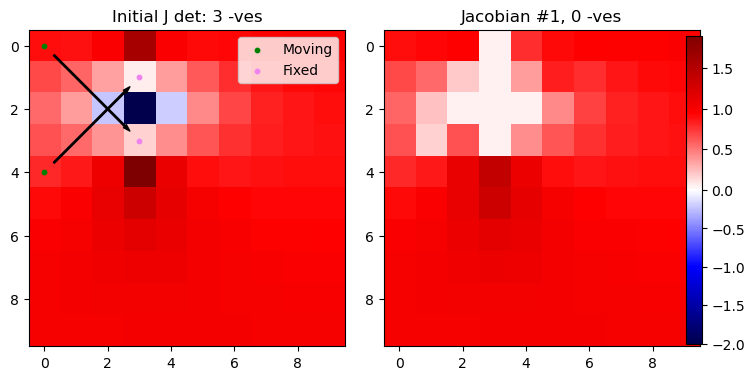

            x-def               y-def            jacobian          
              min       max       min       max       min       max
initial -3.013711 -2.977314 -2.999803  2.999803 -2.003395  1.893126
final   -4.400617 -0.627226 -1.989500  1.834857  0.049999  1.388840
meshgrid shape for plot: (10, 10)
[[[ 0.89126076  0.88649201  0.96400756  1.58394211  0.97360102  0.9065901   0.92879864  0.95207293  0.96609706  0.97211199]
  [ 0.67434955  0.56825474  0.34437072  0.07246907  0.36555203  0.62007237  0.77637465  0.86184539  0.90500563  0.9221917 ]
  [ 0.56162551  0.36726659 -0.22374717 -2.0033955  -0.19642219  0.43519678  0.69436959  0.81377889  0.86940417  0.89126523]
  [ 0.64182308  0.56192132  0.39110896  0.17568873  0.42200789  0.62541714  0.75434954  0.82965913  0.86984911  0.88682344]
  [ 0.79774359  0.84437209  1.05607877  1.8931261   1.08067768  0.891393    0.86707284  0.88018585  0.89376049  0.90111237]
  [ 0.90823824  0.96275502  1.09845439  1.31025733  1.11602031  0.99152123

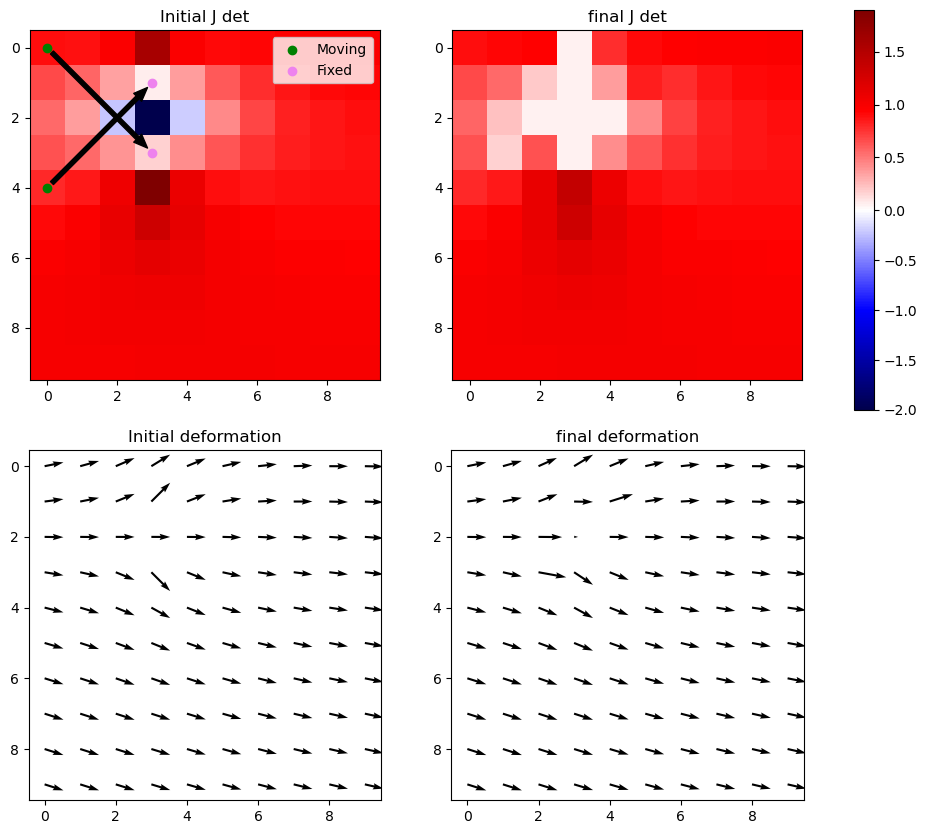

In [14]:
msample = np.array([
    [0, 0, 0],
    [0, 4, 0],
])
fsample = np.array([
    [0, 3, 3],
    [0, 1, 3],
])

fixed_sample = np.zeros((1, 10, 10))
#run_lapl_and_correction(fixed_sample, msample, fsample)
deformation_i, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
print(f'deformation shape: {deformation_i.shape}')
print(deformation_i)
phi_corrected, jacobians = full_slsqp(deformation_i, methodName='SLSQP')
plot_jacobians_iteratively(jacobians, msample, fsample, methodName='SLSQP')
plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10,10))
print(jacobian_det2D(deformation_i[1:]))

deformation shape: (3, 1, 10, 10)
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.4435323767765253
            Iterations: 308
            Function evaluations: 63661
            Gradient evaluations: 307
OP result error: 1.4435323767765253
Deviation from initial = 1.01239251677613
Changed number of -ve jacobians from 2 to 0
Time taken for full SLSQP optimisation: 159.1332986354828s
            x-def              y-def            jacobian          
              min      max       min       max       min       max
initial  0.000000  0.00000 -2.999713  2.999713 -0.356906  1.700982
final   -0.001715  0.00154 -2.996543  2.185967  0.050016  1.698759
meshgrid shape for plot: (10, 10)


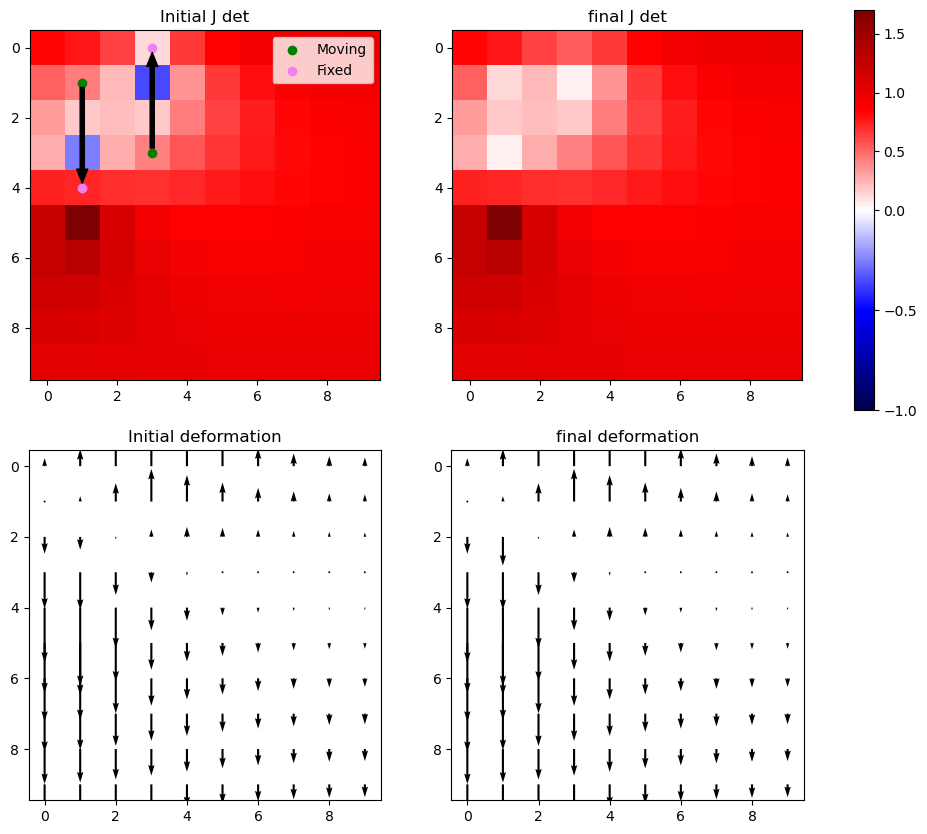

In [15]:
msample = np.array([
    [0, 1, 1],
    [0, 3, 3],
])
fsample = np.array([
    [0, 4, 1],
    [0, 0, 3],
])

fixed_sample = np.zeros((1, 10, 10))
#test_grad(fixed_sample, msample, fsample)
#test_scipy(fixed_sample, msample, fsample)
run_lapl_and_correction(fixed_sample, msample, fsample)

deformation shape: (3, 1, 10, 10)
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.138708485003143
            Iterations: 620
            Function evaluations: 128484
            Gradient evaluations: 616
OP result error: 0.138708485003143
Deviation from initial = 0.1000240563456867
Changed number of -ve jacobians from 0 to 0
Time taken for full SLSQP optimisation: 321.3214681148529s
            x-def                   y-def                jacobian          
              min       max           min           max       min       max
initial -3.999719 -0.999930  0.000000e+00  0.000000e+00  0.008381  1.445456
final   -3.999719 -1.055392 -2.667198e-07  2.110373e-07  0.050000  1.445456
meshgrid shape for plot: (10, 10)


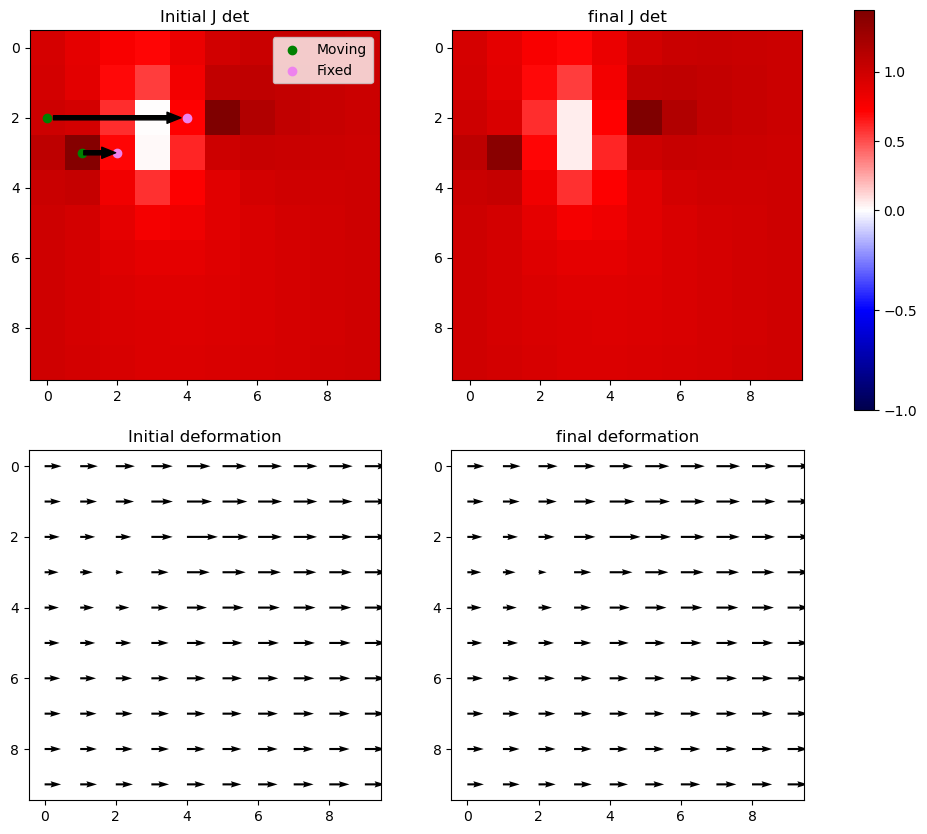

In [16]:
msample = np.array([
    [0, 2, 0],
    [0, 3, 1],
])
fsample = np.array([
    [0, 2, 4],
    [0, 3, 2],
])

fixed_sample = np.zeros((1, 10, 10))
#test_grad(fixed_sample, msample, fsample)
#test_scipy(fixed_sample, msample, fsample)
#red_test_scipy(fixed_sample, msample, fsample)
run_lapl_and_correction(fixed_sample, msample, fsample)

(15, 3) (15, 3)
deformation shape: (3, 1, 20, 40)
deformation_i shape: (3, 1, 20, 40), phi_init shape: (2, 20, 40)
Iteration limit reached    (Exit mode 9)
            Current function value: 227.48858515913167
            Iterations: 1000
            Function evaluations: 1604989
            Gradient evaluations: 1000
Optimisation failed:  Iteration limit reached
Deviation from initial = 24.88082657698265
Changed number of -ve jacobians from 129 to 2
Time taken for full SLSQP optimisation: 6006.9959008693695s
             x-def                y-def            jacobian          
               min        max       min       max       min       max
initial -13.002136  29.004766  0.000000  1.000051 -5.157539  8.077514
final   -13.002403  29.006089 -7.637313  3.573138 -0.021935  6.577832
meshgrid shape for plot: (20, 40)


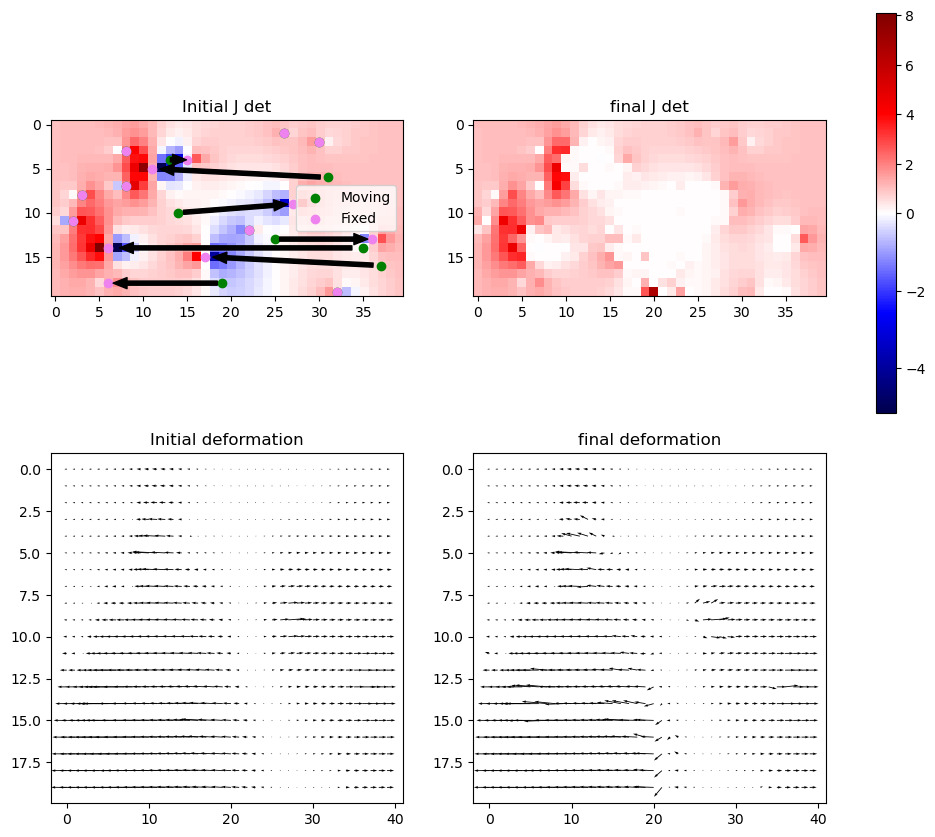

In [18]:
# data analysis

# Create sample set of points
mpoints_path = "data/corrected_correspondences_count_touching/mpoints.npy"
fpoints_path = "data/corrected_correspondences_count_touching/fpoints.npy"

mpoints, fpoints = correspondences.downsample_points(mpoints_path, fpoints_path, debug=False)
#print(mpoints.shape, fpoints.shape) 

fixed_sample = np.zeros((1, 20, 40))

# z values in mpoints, fpoints are for 3 slices numbered 0,1,2
slice_no = 1

# use 
mask = mpoints[:,0]==slice_no
new_mpoints = mpoints[mask].copy()
new_mpoints[:,0] = 0

mask = fpoints[:,0]==slice_no
new_fpoints = fpoints[mask].copy()
new_fpoints[:,0] = 0

print(new_mpoints.shape, new_fpoints.shape)


#test_grad(fixed_sample, msample, fsample)
#red_test_scipy(fixed_sample, new_mpoints[:5], new_fpoints[:5])
run_lapl_and_correction(fixed_sample, new_mpoints, new_fpoints)

## Real slice

In [19]:
# # data analysis

# # Create sample set of points
# mpoints_path = "../data/corrected_correspondences_count_touching/mpoints.npy"
# fpoints_path = "../data/corrected_correspondences_count_touching/fpoints.npy"

# mpoints, fpoints = correspondences.downsample_points(mpoints_path, fpoints_path, debug=False)
# #print(mpoints.shape, fpoints.shape) 

# deformation_field_path = "../data/base_unique_correspondences/registered_output/deformation3d.npy"
# deformation_field = np.load(deformation_field_path)

# # select a slice
# def_shape = deformation_field.shape
# print(def_shape)
# deformation_i = deformation_field[:, 349].reshape((def_shape[0], 1, def_shape[2], def_shape[3]))
# print(deformation_i.shape)
# # z values in mpoints, fpoints are for 3 slices numbered 0,1,2
# slice_no = 0

# # use 
# mask = mpoints[:,0]==slice_no
# new_mpoints = mpoints[mask].copy()
# new_mpoints[:,0] = 0

# mask = fpoints[:,0]==slice_no
# new_fpoints = fpoints[mask].copy()
# new_fpoints[:,0] = 0

# print(new_mpoints.shape, new_fpoints.shape)

# phi_corrected, jacobians = iterative_with_jacobians(deformation_i)
# plot_jacobians_iteratively(jacobians, msample, fsample, methodName='SLSQP')
# plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10,10))
# # kept running for 450min

## Jdet function testing

In [20]:
# global val list
print(list_dev)
print('===')
print(num_neg_jac)
print('=====')
print(time_taken)

# L2
list_dev_L2 = [2.680895253076589, 69.80633869969029, 9.418067274643581, 69.80633869969029, 5.197075330527052, 1.8231005476373714, 2.2589086079637837, 2.8612431766103588, 0.0, 27.945036523729176]

num_neg_jac_init_L2 = [12, 158, 28, 158, 29, 5, 3, 2, 0, 129]

num_neg_jac_L2 = [0, 132, 15, 132, 0, 0, 0, 0, 0, 115]

# L2s
list_dev_L2s = [4.768607942055218, 26.252278493509536, 10026.7948106916, 26.252278493509536, 9.104921565888146, 2.379737612461383, 3.019209538644817, 3.1687868005130904, 0.0, 25.14703328621248]

num_neg_jac_L2s = [0, 137, 15, 137, 0, 0, 0, 0, 0, 109]

# L1

list_dev_L1 = [3.1452826411439276, 49.78213374285741, 12.373348412316172, 49.78213374285741, 12.224721045040889, 2.2478387386726184, 2.419587408528433, 3.1974909624498786, 0.0, 22.553299646732658]

num_neg_jac_L1 = [0, 135, 7, 135, 2, 0, 0, 0, 0, 106]

# L1s
list_dev_L1s = [3.8200316274887136, 27.98726389799386, 11.400909181236925, 27.98726389799386, 7.421816327869949, 2.3274873804728444, 2.952056050877296, 3.112671741644684, 0.0, 21.352944007229933]

num_neg_jac_L1s = [0, 132, 11, 132, 0, 0, 0, 0, 0, 110]

#L2wr
list_dev_L2wr = [1.3388562022484387e-06, 2.1911745978666906, 0.5583311141489217, 2.1911745978666906, 0.00010905921377629281, 8.880030350916757e-08, 8.065887478278329e-07, 8.93188013674346e-08, 0.0, 1.4515563532878142]

num_neg_jac_L2wr = [12, 156, 27, 156, 29, 5, 3, 2, 0, 125]

#L1wr - this
list_dev_L1wr = [1.8719204800182033e-05, 2.800815958456984, 0.6335240860765275, 2.800815958456984, 0.01548376720517454, 3.821057987703311e-05, 2.2714245365299625e-05, 3.223513937255436e-05, 0.0, 2.2229220010626967]

num_neg_jac_L1wr = [12, 156, 29, 156, 29, 5, 3, 2, 0, 123]

#L2swr
list_dev_L2swr = [6.347496024011014, 6.0603622126465195, 8.073554663868867, 6.0603622126465195, 9.805082662138908, 2.4315062468207964, 3.329061274139249, 1.7311478095318673, 0.0, 19.893147478504304]

num_neg_jac_L2swr = [0, 162, 30, 162, 6, 0, 0, 0, 0, 127]
tt_L2swr = [[1.0550048351287842, 15.897326946258545, 5.623910903930664, 16.062530040740967, 12.120941877365112, 0.3773469924926758, 0.3408081531524658, 0.3339860439300537, 0.15784001350402832, 8.772908926010132]
]
ttt_L2swr = 71.68918776512146

#L1swr
list_dev_L1swr = [3.300356140988371, 5.219200883030088, 3.8569020877225846, 5.219200883030088, 4.37866602840255, 1.4021137590566208, 2.0081703705493297, 1.228014013747989, 0.0, 11.192059918711248]

num_neg_jac_L1swr = [11, 156, 28, 156, 19, 4, 3, 0, 0, 121]
tt_L1swr = [38.703429222106934, 85.19641089439392, 57.048078775405884, 85.34915089607239, 37.369688749313354, 21.995036840438843, 18.338409185409546, 3.49845290184021, 0.16025185585021973, 81.12396311759949]

ttt_L1swr = 437.7158851623535

full_end = time.time()
print("time taken is", full_end-full_start)

[0.022994862876051545, 21.514991193353154, 14.586022456917528, 21.514991193353154, 0.0018485499874402274, 2.0722404366878195, 4.385392649190328, 1.01239251677613, 0.1000240563456867, 24.88082657698265]
===
[12, 0, 2, 0, 29, 0, 0, 0, 0, 2]
=====
[5987.0680372715, 5916.094465017319, 5769.77891087532, 5627.4552257061005, 5455.7939467430115, 169.70629239082336, 507.77321100234985, 159.1332986354828, 321.3214681148529, 6006.9959008693695]
time taken is 47770.14039373398
